In [1]:
from collections import defaultdict
import csv
from sklearn import linear_model
from sklearn.decomposition import PCA
import scipy
import scipy.optimize
import numpy
import random

In [2]:
def readCSV(path):
  f = open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')
    
def calc_model_stats(pred,label):
    
    TP,FP,TN,FN = calc_metrics(pred,label)

    # print("Stats")
    # print(TP,FP,TN,FN)

    # print("Predict N: {} ({}%)".format(TN+FN,(TN+FN)/(TP+TN+FP+FN)))
    # print("Predict P: {} ({}%)".format(TP+FP,(TP+FP)/(TP+TN+FP+FN)))

    accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Accuracy: {}".format(accuracy))
    # print("TPR: {}".format(TPR))
    # print("TNR: {}".format(TNR))
    # print("BER: {}".format(BER))
    
    return
 
def calc_metrics(predictions, labels):
    # Calculate True positives, false positives, etc.

    TP_ = numpy.logical_and(predictions, labels)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(labels))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(labels))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), labels)

    TP=sum(TP_)
    FP=sum(FP_)
    TN=sum(TN_)
    FN=sum(FN_)
    
    return TP,FP,TN,FN

def calc_error_rates(TP, FP, TN, FN):
    # Calculate accuracy, TPR, TNR and BER
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    BER = 1.0 - (TPR+TNR)/2
    
    return accuracy, TPR, TNR, BER


### Generate lists and sets for Similarity Calculations

#### Jaccard Similarity between Books

Jsim(i,j) = Intersection(U_i, U_j)/ Union(U_i, U_j)  

where U_i, U_j are set of readers who have read book i and book j  

#### Pearson Similarity between Books


Psim(i,j) = Sum_Product_crij((R_u_i-AR_u), (R_u_j-AR_u))/ SqRt(Sum_crij(Sq(R_u_i-AR_u)))SqRt(Sum_crij(Sq(R_u_j-AR_u)))  

where 
* crij - the set of readers who have read both book i and j  
* R_u_i = Rating that reader u gives book i  
* AR_u = Average rating given by reader u  





In [4]:
user_Books_full = defaultdict(set)  # Set of (user, books_read)
user_Books_Ratings_full = defaultdict(set)  # Set of (user, set(book_read, rating))
book_Readers_full = defaultdict(set)  # Set of (book, readers)
book_ids=[]

for user,book,rating in X:
  user_Books_full[user].add(book)
  user_Books_Ratings_full[user].add((book,rating))
  book_Readers_full[book].add(user)
  if book not in book_ids:
        book_ids.append(book)

NameError: name 'X' is not defined

In [20]:
len(user_Books_full),len(user_Books_Ratings_full),len(book_Readers_full), len(book_ids)

(11357, 11357, 7170, 7170)

In [21]:
user_Books_train = defaultdict(set)
user_Books_Ratings_train = defaultdict(set)
book_Readers_train = defaultdict(set)
book_Ratings_train = defaultdict(set)

for user,book,rating in Xtrain:
  user_Books_train[user].add(book)
  user_Books_Ratings_train[user].add((book,rating))
  book_Readers_train[book].add(user)
  book_Ratings_train[book].add(rating)


In [22]:
len(user_Books_train),len(user_Books_Ratings_train),len(book_Readers_train),len(book_Ratings_train)

(11357, 11357, 7170, 7170)

In [5]:
def list_pad(l, n):
    # if len(l) > n, the method truncates the list l to length n 
    # if n > len(l), the method pads list l with zero up to length n 
    return l[:n] + [0]*(n-len(l))

def find_rating(reader,book):
    rating = 0
    for b, rating in user_Books_Ratings_train[reader]:
        if book == b:
            return int(rating)
    return int(rating)

def average_rating(reader):
    ratings = []
    for _, rating in user_Books_Ratings_train[reader]:
        ratings.append(int(rating))
    
    if len(ratings) == 0:
        return 0
    
    return sum(ratings)/len(ratings)

def unread_book(user, read_books):
    # Find a random unread book for a specific user
    
    book = random.choice(book_ids)  # pick a book from full library
    while book in read_books:
        book = random.choice(book_ids)
    return book

"""
Jaccard Similarity
"""

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

"""
When evaluating whether a reader will read a certain book, we can approach it in two ways:
(1) Is the book similar to all the other books the reader has read?
(2) Is the reader similar to all the other readers who have read the same book?
"""

def items_jsim(book1, book2):
    # generate readers set for the 2 books based on train dataset
    s1 = book_Readers_train[book1]
    s2 = book_Readers_train[book2]
    return Jaccard(s1, s2)

def users_jsim(reader1, reader2):
    # generate Books set for the 2 readers based on train dataset
    s1 = user_Books_train[reader1]
    s2 = user_Books_train[reader2]
    return Jaccard(s1, s2)

def jsim_mostSimilar_items(r,b):
    # Find books read by reader r that are most similar to book b
    # and return Jaccard(b, book) in descending order
    jsims = []
    
    # Go through the books read by reader r
    for other_book in user_Books_train[r]:
        if b == other_book: 
           continue   # skip if the book is b
        jsim = items_jsim(b, other_book)
        jsims.append(jsim)
       
    jsims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return jsims  

def jsim_mostSimilar_users(b,r):
    # Find readers who read book b that are most similar to the reader r
    # and return Jaccard(r, reader) in descending order
    jsims = []
    
    # Go through the readers who read book b
    for reader in book_Readers_train[b]:
        if r == reader: 
           continue   # skip if the reader is r
        jsim = users_jsim(r, reader)
        jsims.append(jsim)
       
    jsims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return jsims  


def jaccard_predict(user, book, threshold):
    """
    user_jsims = jsim_mostSimilar_users(book,user)
    if len(user_jsims) is 0:
        max_jsim = 0
    else:
        max_jsim = user_jsims[0]
    """    
    book_jsims = jsim_mostSimilar_items(user,book)
    if len(book_jsims) is 0:
        max_jsim = 0
    else:
        max_jsim = book_jsims[0]
        
    if max_jsim > threshold:
        predict = True
    else:
        predict = False
    return predict, max_jsim

"""
Pearson Similarity

When evaluating whether a reader will read a certain book, we can approach it in two ways:
(1) Is the book similar to all the other books the reader has read?
(2) Is the reader similar to all the other readers who have read the same book?
"""

def users_Pearson(r1,r2):
    
    books_r1 = set([])
    ratings_r1 = []
    
    for book,rating in user_Books_Ratings_train[r1]:
        # print (book,rating)
        books_r1.add(book)
        ratings_r1.append(int(rating))
        
    if len(ratings_r1) == 0:
        avRating_r1 = 0
    else:
        avRating_r1 = sum(ratings_r1)/len(ratings_r1)
        
    # print(books_r1)
    # print(avRating_r1)
    
    books_r2 = set([])
    ratings_r2 = []
    
    for book,rating in user_Books_Ratings_train[r2]:
        # print (book,rating)
        books_r2.add(book)
        ratings_r2.append(int(rating))
        
    if len(ratings_r2) == 0:
        avRating_r2 = 0
    else:
        avRating_r2 = sum(ratings_r2)/len(ratings_r2)  
    
    # print(books_r2)
    # print(avRating_r2)
        
    common = books_r1.intersection(books_r2)
    if len(common) == 0:  # return psim=0 if no common book
        return 0
        
    # print(common)
    
    sumProducts = []
    sumSq_R1 = []
    sumSq_R2 = []
    for book in common:
        pR_r1 = find_rating(r1,book) - avRating_r1
        pR_r2 = find_rating(r2,book) - avRating_r2
        # print(find_rating(r1,book), pR_r1)
        # print(find_rating(r2,book), pR_r2)
        sumProducts.append(pR_r1*pR_r2)
        sumSq_R1.append(pR_r1**2)
        sumSq_R2.append(pR_r2**2)
        
    if sum(sumSq_R1) == 0 or sum(sumSq_R2) == 0:
        return 0
        
    # print(sumProducts)
    # print(sumSq_R1)
    # print(sumSq_R2)
    
    psim = sum(sumProducts)/math.sqrt(sum(sumSq_R1)*sum(sumSq_R2))
    return psim

def items_Pearson(b1,b2):
    
    # Create a set of common readers for book b1 and b2
    readers_b1 = set([])
    for reader in book_Readers_train[b1]:
        readers_b1.add(reader)
        
    readers_b2 = set([])
    for reader in book_Readers_train[b2]:
        readers_b2.add(reader)
        
    common = readers_b1.intersection(readers_b2)
    if len(common) == 0:  # return psim=0 if no common readers
        return 0
        
    # print(common)
    
    sumProducts = []
    sumSq_R1 = []
    sumSq_R2 = []
    for reader in common:
        avRating = average_rating(reader)
        # print(avRating)
        pR_b1 = find_rating(reader,b1) - avRating
        pR_b2 = find_rating(reader,b2) - avRating
        # print(find_rating(reader,b1), pR_b1)
        # print(find_rating(reader,b2), pR_b2)
        sumProducts.append(pR_b1*pR_b2)
        sumSq_R1.append(pR_b1**2)
        sumSq_R2.append(pR_b2**2)
        
    if sum(sumSq_R1) == 0 or sum(sumSq_R2) == 0:
        return 0
        
    # print(sumProducts)
    # print(sumSq_R1)
    # print(sumSq_R2)
    
    psim = sum(sumProducts)/math.sqrt(sum(sumSq_R1)*sum(sumSq_R2))
    return psim

def psim_mostSimilar_users(b,r):
    # Find readers who read book b that are most similar to the reader r
    # and return Pearson(r, reader) in descending order
    psims = []
    
    # Go through the readers who read book b
    for reader in book_Readers_train[b]:
        if r == reader: 
           continue   # skip if the reader is r
        psim = users_Pearson(r, reader)
        # print (reader, psim)
        psims.append(psim)
       
    psims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return psims  

def psim_mostSimilar_items(r,b):
    # Find books read by reader r that are most similar to the book b
    # and return Pearson(b, book) in descending order
    psims = []
    
    # Go through the books read by reader r 
    for book in user_Books_train[r]:
        if book == b: 
           continue   # skip if the book is b
        psim = items_Pearson(b, book)
        # print (book, psim)
        psims.append(psim)
       
    psims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return psims  
    

### Split Training Dataset into Train and Validation Datasets

In [3]:
dataset = []

for user,book,rating in readCSV("assignment1/train_Interactions.csv"):
  dataset.append([user,book,rating])

random.shuffle(dataset)

X = [values[0:2] for values in dataset]
y = [int(values[-1]) for values in dataset]

N = len(dataset)
Ntrain = 190001

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:]

print(N, len(ytrain),len(yvalid))

200000 190001 9999


### Adopt code from Workbook 4

In [4]:
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

for user,book,rating in dataset:
    ratingsPerUser[user].append(rating)
    ratingsPerItem[book].append(rating)

N = len(Xtrain)
nUsers = len(ratingsPerUser)
nItems = len(ratingsPerItem)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

print (nUsers, nItems)
print (users[:3])
print (items[:3])

11357 7170
['u75986052', 'u17942143', 'u00245273']
['b38443676', 'b20871741', 'b46766137']


In [5]:
ratingMean = sum([y for y in ytrain])/len(ytrain)

print("Mean of ratings in training set: {}".format(ratingMean))

Mean of ratings in training set: 3.896490018473587


In [9]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for value in zip(Xtrain,ytrain):
        x,rating = value
        user = x[0]
        book = x[1]
        pred = prediction(user,book)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[user] += 2/N*diff
        dItemBiases[book] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return numpy.array(dtheta)

In [10]:
alwaysPredictMean = [ratingMean for d in Xtrain]

MSE(alwaysPredictMean, ytrain)

1.4746158551964967

In [11]:
numpy.var(ytrain)

1.4746158551939172

## (9) Lambda=1.0, MSE=1.509 for Validation Set

In [15]:
lamb = 1.0
theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),derivative, args = (ytrain, lamb))

MSE = 1.4731564256297192
MSE = 1.455708491441564
MSE = 1.4730066120374512
MSE = 1.4730068696756777
MSE = 1.4730066177516945
MSE = 1.4730066121675425
MSE = 1.4730066120404
MSE = 1.473006612037573
MSE = 1.4730066120374525
MSE = 1.4730066120374512
MSE = 1.4730066120374496
MSE = 1.4730066120374496
MSE = 1.4730066120374508
MSE = 1.4730066120374496
MSE = 1.473006612037451
MSE = 1.4730066120374496
MSE = 1.4730066120374496
MSE = 1.47300661203745
MSE = 1.4730066120374496
MSE = 1.4730066120374508
MSE = 1.4730066120374496


### Extract alpha and betas

In [16]:
unpack(theta)

In [17]:
alpha

3.8967426487228924

In [18]:
predictions = [prediction(user, book) for user,book in Xvalid]
cost = MSE(predictions, yvalid)

print(cost)

1.4982149392405215


## (10) 'u11591742' and 'b57299824' have highest betas

In [19]:
sorted_userBiases  = sorted(userBiases.items(), key=lambda x:x[1])

sorted_userBiases[:10]

[('u11591742', -0.0015229974227424891),
 ('u39338306', -0.0012046010652446205),
 ('u48159222', -0.0008497381739954822),
 ('u00087472', -0.0007321491665724385),
 ('u15620043', -0.0006482229595105764),
 ('u51233768', -0.0006183425164041663),
 ('u76571258', -0.0006093620730744994),
 ('u74183154', -0.0005933062271676205),
 ('u80513837', -0.0005463358657893766),
 ('u00713548', -0.0005189052238680386)]

In [20]:
sorted_itemBiases  = sorted(itemBiases.items(), key=lambda x:x[1])

sorted_itemBiases[:10]

[('b57299824', -0.00027942781558469847),
 ('b47900823', -0.00022407721980972485),
 ('b71442874', -0.00021917761743954465),
 ('b38779837', -0.0002093262057223682),
 ('b81528778', -0.00020731350949277974),
 ('b84203038', -0.00020083507432501843),
 ('b22593148', -0.00019115000810877167),
 ('b47305082', -0.00018581330078309044),
 ('b04083790', -0.0001815139073458508),
 ('b38443676', -0.00018083376718593718)]

In [28]:
lamb_values = [8e-6,1e-5,1.25e-5,1.5e-5,1.6e-5,1.7e-5,1.8e-5,2e-5,5e-5]
MSE_valid =[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems)
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in userBiases:
            cost += lamb*userBiases[u]**2
        for i in itemBiases:
            cost += lamb*itemBiases[i]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        for value in zip(Xtrain,ytrain):
            x,rating = value
            user = x[0]
            book = x[1]
            pred = prediction(user,book)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[user] += 2/N*diff
            dItemBiases[book] += 2/N*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 8e-06
MSE = 1.4805441297166555
MSE = 2.2975032938044913
MSE = 1.4730802389857092
MSE = 1.47283439867937
MSE = 1.47245754248562
MSE = 1.4712028251923286
MSE = 1.468214525005397
MSE = 1.4603205464946034
MSE = 1.4412012310426663
MSE = 1.3985802959211986
MSE = 1.3240231683245256
MSE = 1.2422098107741841
MSE = 1.2013979809025106
MSE = 1.1948764468321484
MSE = 1.1947004618980506
MSE = 1.1943469354789478
MSE = 1.1909235784485865
MSE = 1.1822434666020247
MSE = 1.1608308765149138
MSE = 1.1234835769880327
MSE = 1.0825351175209923
MSE = 1.0616086532523175
MSE = 104.1917756629133
MSE = 1.0574743990729425
MSE = 1.055236289984109
MSE = 1.0540357232641846
MSE = 1.049017357338321
MSE = 1.033377106858927
MSE = 1.011601662942796
MSE = 0.9888519577319868
MSE = 0.9804194113980523
MSE = 0.9785713266891976
MSE = 0.9646743416651443
MSE = 0.9510175622929047
MSE = 0.9518991056066791
MSE = 0.9494408362594754
MSE = 0.9484913864572868
MSE = 0.9366580187161991
MSE = 0.9332381583327394
MSE = 0.932679622052

MSE = 105.76255610054432
MSE = 1.0577691485372116
MSE = 1.0557591618186075
MSE = 1.054564757093724
MSE = 1.0490476600905911
MSE = 1.032607880589378
MSE = 1.0103063798835161
MSE = 0.9967412014877979
MSE = 0.9920438917310186
MSE = 0.9798102890461735
MSE = 0.9780386440306521
MSE = 0.9761513250214595
MSE = 0.9717939651752765
MSE = 0.9660331019888979
MSE = 1.0037419506054432
MSE = 0.964365127012074
MSE = 0.9599806391830504
MSE = 0.9586880240616912
MSE = 0.9584415607629565
MSE = 0.9582416613323613
MSE = 0.9573910784172943
MSE = 0.9554122866155547
MSE = 0.9509967891634968
MSE = 0.9514182772278326
MSE = 0.9491705229540813
MSE = 0.9386603597670584
MSE = 0.9338792292111261
MSE = 0.9302212901929066
MSE = 0.930393711650286
MSE = 0.9301633064231212
MSE = 0.9298022666350748
MSE = 0.9292453034277305
MSE = 0.9284333816589587
MSE = 0.9276407950392705
MSE = 0.9264983334393158
MSE = 0.9300959259844594
MSE = 0.9263887570365507
MSE = 0.9252138432932245
MSE = 0.9246286609528219
MSE = 0.9245158464850157
MSE 

MSE = 0.9722110003889675
MSE = 0.9671457407134592
MSE = 0.9642703689137863
MSE = 0.9610877437639804
MSE = 0.9610958128075426
MSE = 0.960027747528872
MSE = 0.9593527164182097
MSE = 0.9565655094002392
MSE = 0.9537735811777921
MSE = 0.9493619296206965
MSE = 1.2670741596021977
MSE = 0.9477755284013457
MSE = 0.9416206926697637
MSE = 0.9389399216626872
MSE = 0.938794329713487
MSE = 0.939319613546046
MSE = 0.9403628508264337
MSE = 0.9429574735116717
MSE = 0.9395376891873632
MSE = 0.9410157838582244
MSE = 0.9408671864971365
MSE = 0.9392948141157442
MSE = 0.9368337984415894
MSE = 0.9300417127611366
MSE = 1.447120018969379
MSE = 0.9309884307709236
MSE = 0.928438645886971
MSE = 0.9419943268733131
MSE = 0.927690974111649
MSE = 0.9273925992583073
MSE = 0.9254843580967936
MSE = 0.9925825870999461
MSE = 0.9252220470579163
MSE = 0.9228147837862536
MSE = 0.9209517471557699
MSE = 0.9213260979954097
MSE = 0.9216204773431506
MSE = 0.9214485146709392
MSE = 0.9206021537370788
MSE = 0.9205877809178634
MSE = 

MSE = 1.058185690058122
MSE = 1.0564893970431979
MSE = 1.0550816888301067
MSE = 1.0474779574781796
MSE = 1.0283836615326876
MSE = 1.0045501501976897
MSE = 0.9821259962735708
MSE = 0.9829830352545926
MSE = 0.9747100159312461
MSE = 0.9674659639191807
MSE = 0.9533492574694037
MSE = 0.9459666687428229
MSE = 0.9442386297937894
MSE = 0.9448156403040556
MSE = 0.9438206995215884
MSE = 0.942508593401262
MSE = 0.9419405177149218
MSE = 0.9386062703805149
MSE = 0.9382362790943142
MSE = 0.9335537614279774
MSE = 0.9324818823027092
MSE = 0.9320807624004755
MSE = 0.9320823838449707
MSE = 0.9317012903233746
MSE = 0.9314576256290085
MSE = 0.9297290863752482
MSE = 1.5397941261367567
MSE = 0.9296228230996194
MSE = 0.928284077258966
MSE = 0.9271570060255965
MSE = 0.9267759308622486
MSE = 0.9264788073300421
MSE = 0.9254864905233111
MSE = 0.9231348540886759
MSE = 0.9235986313582699
MSE = 0.9227448003310729
MSE = 0.921542685345424
MSE = 0.920624061057265
MSE = 0.9225892240688237
MSE = 0.9212541347340449
MSE =

In [29]:
MSE_valid

[1.1108039952167454,
 1.1090961226343612,
 1.108149717595015,
 1.1080827441140344,
 1.107547823541491,
 1.1070277944583267,
 1.1068034364209327,
 1.1325100917364426,
 1.182853662863315]

In [24]:
best_MSE

1.1244750401368946

## (11) Kaggle Submission - Lambda=1.2e-5,  MSE=1.143, User_Name='Luke Liem'

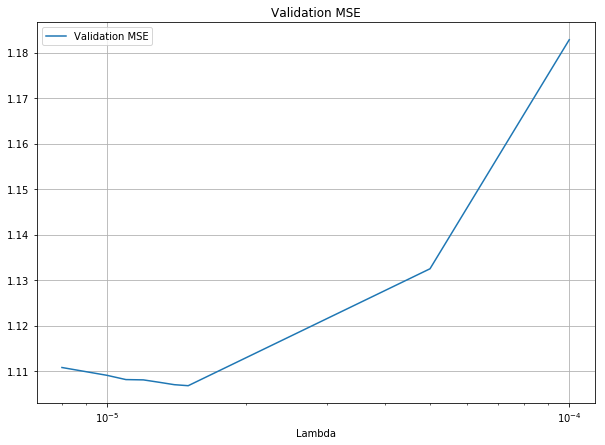

In [30]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.xlabel('Lambda')
plt.title('Validation MSE')
plt.xscale('log')
plt.grid(True)

plt.plot(lamb_values, MSE_valid, label='Validation MSE')

plt.legend()
plt.show()

In [31]:
best_theta

array([ 3.81232674,  0.65968155,  0.19523218, ..., -0.23033841,
        0.0180167 , -0.04204099])

In [32]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()

In [6]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

userGamma = {}
itemGamma = {}

K = 2

# Initialize user and item Gammas
for u in ratingsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in ratingsPerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

In [9]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K
        
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

   
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost


def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in ratingsPerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in ratingsPerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for value in zip(Xtrain,ytrain):
        x,rating = value
        u = x[0]
        i = x[1]
        pred = prediction(u, i)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [14]:
lamb = 0.001
theta_init = [alpha] + [0.0]*(nUsers+nItems) +  \
            [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))]
scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

MSE = 1.474619170407238
MSE = 1.4599767305551148
MSE = 10.631338742893119
MSE = 1.4586447196982086
MSE = 1.3635293338665302
MSE = 1.3632068120221164
MSE = 1.362121147872239
MSE = 1.3620918514138083
MSE = 1.3626038932680928
MSE = 1.3621942951217672
MSE = 1.362820225789831
MSE = 1.3622779403871934
MSE = 1.3622074017639232
MSE = 1.3621963977635856
MSE = 1.3621946337053565
MSE = 1.3621943496759454
MSE = 1.3621943039125155
MSE = 1.3621942965383111
MSE = 1.362194295350019
MSE = 1.3621942951585282
MSE = 1.3621942951277297
MSE = 1.3621942951226316
MSE = 1.3621942951218753
MSE = 1.3621942951217705
MSE = 1.3621942951217705
MSE = 1.3621942951218196
MSE = 1.3621942951217758
MSE = 1.362194295121776
MSE = 1.3621942951217758


(array([ 3.88009378e+00,  1.42796968e-02, -1.57531769e-01, ...,
        -3.73682860e-04,  4.52345064e-04, -1.62430968e-04]),
 1.411087147937743,
 {'funcalls': 29,
  'grad': array([ 2.03082266e-05, -1.41875927e-07, -6.32163915e-06, ...,
         -7.52928321e-07,  9.05633364e-07, -3.30601986e-07]),
  'nit': 7,
  'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

In [19]:
lamb_values = [1e-4, 9e-5, 8e-5, 7e-5, 6e-5, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
MSE_valid =[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems) +  \
            [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))]
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in users:
            cost += lamb*userBiases[u]**2
            for k in range(K):
                cost += lamb*userGamma[u][k]**2
        for i in items:
            cost += lamb*itemBiases[i]**2
            for k in range(K):
                cost += lamb*itemGamma[i][k]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        dUserGamma = {}
        dItemGamma = {}
        for u in ratingsPerUser:
            dUserGamma[u] = [0.0 for k in range(K)]
        for i in ratingsPerItem:
            dItemGamma[i] = [0.0 for k in range(K)]
        for value in zip(Xtrain,ytrain):
            x,rating = value
            u = x[0]
            i = x[1]
            pred = prediction(u, i)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[u] += 2/N*diff
            dItemBiases[i] += 2/N*diff
            for k in range(K):
                dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
                dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
            for k in range(K):
                dUserGamma[u][k] += 2*lamb*userGamma[u][k]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
            for k in range(K):
                dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        for u in users:
            dtheta += dUserGamma[u]
        for i in items:
            dtheta += dItemGamma[i]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 0.0001
MSE = 1.4814165619973236
MSE = 2.301654950741493
MSE = 1.4742779665742929
MSE = 1.474034390443018
MSE = 1.4736473925090485
MSE = 1.472385990019659
MSE = 1.4693623170601755
MSE = 1.4613766183492054
MSE = 1.4418694661766271
MSE = 1.3977510604109957
MSE = 1.3200609829598224
MSE = 1.2323783694666288
MSE = 1.1932857889785164
MSE = 1.1934491363024977
MSE = 1.1952110458488785
MSE = 1.1963587274196437
MSE = 1.1938513122298398
MSE = 1.1803528549921996
MSE = 1.1467362773345398
MSE = 5.004826079944842
MSE = 1.1499486017192415
MSE = 1.1260586481125894
MSE = 1.1180842527710715
MSE = 1.1175964717281661
MSE = 1.1173279893073598
MSE = 1.1153408104374085
MSE = 1.1093302347345118
MSE = 1.0981477057791589
MSE = 1.08328184097005
MSE = 1.0964748070521324
MSE = 1.0878211081211902
MSE = 1.0830954854706623
MSE = 1.083259447781116
MSE = 1.0837360338402782
MSE = 1.0848088708569341
MSE = 1.1428347299463806
MSE = 1.0845147050658748
MSE = 1.0855334884377503
MSE = 1.0789809821673597
MSE = 1.07673426

MSE = 1.033098906479447
MSE = 1.0315190812132415
MSE = 1.02748851328486
MSE = 1.078028301854893
MSE = 1.0296910686651313
MSE = 1.0280133411292374
MSE = 1.0236388225538842
MSE = 1.0242503885882694
MSE = 1.0247833109335465
MSE = 1.0245131867373376
MSE = 1.0237634896522958
MSE = 1.0239766830761667
MSE = 1.0228178806367523
MSE = 1.0220023554126014
MSE = 1.0212744984016777
MSE = 1.0211994837601528
MSE = 1.020913242910705
MSE = 1.0204627095219818
MSE = 1.0193458438178753
MSE = 1.0182027360621737
MSE = 1.0185252090575752
MSE = 1.018773891460244
MSE = 1.0190831219044822
MSE = 1.0190644455191
MSE = 1.0204374093952835
MSE = 1.0192936833500403
MSE = 1.0195934724861204
MSE = 1.0203480295663816
MSE = 1.0202242859653268
MSE = 1.0210485882112998
MSE = 1.0203590977686305
MSE = 1.0202503681731419
MSE = 1.020229489409858
MSE = 1.0202253303752562
MSE = 1.0202244958488196
MSE = 1.0202243281537255
MSE = 1.0202242944460367
MSE = 1.0202242876700658
MSE = 1.0202242863078297
MSE = 1.0202242860339978
MSE = 1.02

MSE = 1.0029651102902646
MSE = 0.9954613443979764
MSE = 0.9945470036471972
MSE = 0.9927499970152213
MSE = 1.0870228846637506
MSE = 0.995313723841822
MSE = 0.9924721774702676
MSE = 0.9954285842177998
MSE = 0.9930976405904443
MSE = 0.9914119750811955
MSE = 0.9894546907956118
MSE = 0.989830207896398
MSE = 0.990606926307542
MSE = 0.9905458636394968
MSE = 0.9894742954187769
MSE = 0.9877817558960978
MSE = 0.9862374289063274
MSE = 0.9854939921531793
MSE = 0.9866162536334611
MSE = 0.9857191757909841
MSE = 0.9867322308182884
MSE = 0.9860171681339328
MSE = 0.9884426920763002
MSE = 0.9862920757788174
MSE = 0.9860638715718005
MSE = 0.9860255836927009
MSE = 0.9860187003819189
MSE = 0.9860174476415694
MSE = 0.9860172191381126
MSE = 0.9860171774416757
MSE = 0.9860171698323575
MSE = 0.986017168443885
MSE = 0.9860171681903095
MSE = 0.9860171681441868
MSE = 0.9860171681356918
MSE = 0.9860171681341934
MSE = 0.986017168133953
MSE = 0.9860171681341094
MSE = 0.9860171681339763
MSE = 0.9860171681339538
MSE =

MSE = 0.8152822762689218
MSE = 1.1310837237950955
MSE = 0.821791806582709
MSE = 0.8215765348440414
MSE = 0.8213120158523722
MSE = 0.8173686928862438
MSE = 0.8121199068183309
MSE = 0.8120352601197315
MSE = 0.812125537966641
MSE = 0.8122029382925728
MSE = 0.8115733149666269
MSE = 0.8067177953080898
MSE = 0.8037417009886169
MSE = 0.8048502479192513
MSE = 0.8013538765750193
MSE = 0.7974649958381944
MSE = 0.7974343044028025
MSE = 0.7993490172481477
MSE = 0.7976733952880097
MSE = 0.7982740765608594
MSE = 0.7966077342670853
MSE = 0.7974717549054509
MSE = 0.7968792934873374
MSE = 0.7964809248146695
MSE = 0.7921541434747218
MSE = 0.7914568851233319
MSE = 1.1053667357806218
MSE = 0.7919176667575378
MSE = 0.7887794347770577
MSE = 0.7909458097707828
MSE = 0.7894068717039785
MSE = 0.7870853071805626
MSE = 0.7839864768305849
MSE = 0.7861054419050281
MSE = 0.7845003488495387
MSE = 0.7840623720722306
MSE = 0.7827200834305122
MSE = 0.7811747043749422
MSE = 0.7815526426564823
MSE = 0.7809033818705409
MS

MSE = 0.7402796244807999
MSE = 0.7402796049902417
MSE = 0.7402796020246427
MSE = 0.7402796015734002
MSE = 0.74027960150473
MSE = 0.7402796014943405
MSE = 0.7402796014926031
MSE = 0.7402796014937357
MSE = 0.7402796014927907
MSE = 0.7402796014934172
MSE = 0.7402796014928729
MSE = 0.7402796014927938
MSE = 0.7402796014927907
1.199644783486344
Lambda = 2e-05
MSE = 1.479389356719903
MSE = 2.3213531055147705
MSE = 1.4742659840260357
MSE = 1.4740404604757509
MSE = 1.4735850387579925
MSE = 1.4722619656085325
MSE = 1.468965488101078
MSE = 1.460430410649449
MSE = 1.4397038819269488
MSE = 1.394107127125086
MSE = 1.3162519898260483
MSE = 1.2342558846326337
MSE = 1.197122694455185
MSE = 1.1932126695897387
MSE = 1.1935542907790166
MSE = 1.1933744201100231
MSE = 1.1906619296804801
MSE = 1.182629680520465
MSE = 1.1612815711084705
MSE = 1.1236546805356447
MSE = 1.0848837411906644
MSE = 1.06084786181147
MSE = 1.4402941127957714
MSE = 1.057048178247519
MSE = 1.054308321714508
MSE = 1.0446645978196145
MSE 

MSE = 0.670654859405372
MSE = 0.6700637139463378
MSE = 0.7439038784853401
MSE = 0.6700676896900952
MSE = 0.6698666440944703
MSE = 0.6672445370085553
MSE = 0.6693833266103671
MSE = 0.6671990811386833
MSE = 0.6670009632736089
MSE = 0.6672058170096126
MSE = 0.6668846889261668
MSE = 0.6667512025898124
MSE = 0.6664321621810119
MSE = 0.6660712491226224
MSE = 0.6656418895267323
MSE = 0.6653480851934357
MSE = 0.6653985568009105
MSE = 0.6653166398798919
MSE = 0.660770989902761
MSE = 0.6646976875556438
MSE = 0.6649693689575843
MSE = 1.8216719519034714
MSE = 0.6650502383711673
MSE = 0.6649923201541708
MSE = 0.6654678299008426
MSE = 0.6651269858163577
MSE = 0.6655405579406866
MSE = 0.6655917313949519
MSE = 0.6654207868501196
MSE = 0.6658031897039474
MSE = 0.6654545497806752
MSE = 0.6638737157967262
MSE = 0.6627351740018774
MSE = 0.6615306488374698
MSE = 0.661348877948068
MSE = 0.6605300658211152
MSE = 0.6616964209619894
MSE = 0.6605677988987411
MSE = 0.6604578929686862
MSE = 0.660362378250057
MSE 

MSE = 0.6773865910251294
MSE = 0.6809492434079315
MSE = 0.6764673276676079
MSE = 0.6718911653816155
MSE = 0.6669336683804804
MSE = 0.6684701378724691
MSE = 0.6665251691511023
MSE = 3.1765818084836397
MSE = 0.6666230293602481
MSE = 0.6666243429137433
MSE = 0.66531245113229
MSE = 0.6633308897823509
MSE = 0.6583059241945695
MSE = 0.6882124504263946
MSE = 0.6575684640402174
MSE = 0.6545780043376741
MSE = 0.6523403946913074
MSE = 0.6514203252246278
MSE = 0.6505213418564192
MSE = 0.6503131308782019
MSE = 3.1537123459099052
MSE = 0.6503825846912554
MSE = 0.6511394545482773
MSE = 0.6515959627202904
MSE = 0.6518491668578243
MSE = 0.6516902522107632
MSE = 0.650929669880572
MSE = 0.6485363702632767
MSE = 0.6453575361648879
MSE = 0.6435991755638474
MSE = 0.6425908283754749
MSE = 0.641200182152844
MSE = 0.6439571350712355
MSE = 0.6408901896214149
MSE = 0.6408584962246089
MSE = 0.6411957118861324
MSE = 0.6418986351082022
MSE = 0.6413257029317008
MSE = 0.641087867677809
MSE = 0.641387720130573
MSE = 

MSE = 0.5774985695116522
MSE = 0.5774901244137453
MSE = 0.5796214948975666
MSE = 0.5775887912995371
MSE = 0.577629080293107
MSE = 0.5774661148215366
MSE = 0.5775748990789452
MSE = 0.577301293619485
MSE = 0.5773614707641341
MSE = 0.5772578554996451
MSE = 0.5773019706506634
MSE = 0.5772569944057286
MSE = 0.5771483515549467
MSE = 0.5769671041764431
MSE = 0.5768620766605904
MSE = 0.5770147442649661
MSE = 0.5772096129612891
MSE = 0.5769586038257187
MSE = 0.5772683588074986
MSE = 0.5773974143323957
MSE = 0.5774706085082859
MSE = 0.5775587215520044
MSE = 0.5777161110290708
MSE = 0.5774434201269766
MSE = 0.5775733392414673
MSE = 0.5775848795852411
MSE = 0.5775027069048069
MSE = 0.5774472171449876
MSE = 0.5772962105558962
MSE = 0.5770655083587156
MSE = 0.5840742547819999
MSE = 0.5769841473954276
MSE = 0.5767213533365089
MSE = 0.5779848989225942
MSE = 0.5769565430585818
MSE = 0.5767584907421036
MSE = 0.5768051161889046
MSE = 0.5769040691891932
MSE = 0.5768873959730518
MSE = 0.576862457019914
MSE

MSE = 0.5659876898098581
MSE = 0.5660025272812647
MSE = 0.5660044531616789
MSE = 0.5659809202165715
MSE = 0.5659479014533885
MSE = 0.5657876226890417
MSE = 0.5659966275847991
MSE = 0.5658426925843069
MSE = 0.5658228661527654
MSE = 0.565850672983512
MSE = 0.5658567961032419
MSE = 0.5658437805923311
MSE = 0.5656843564633149
MSE = 0.5653160785752055
MSE = 0.5653544988703855
MSE = 0.5653865675670435
MSE = 0.5653956961855243
MSE = 0.5654179285993102
MSE = 0.5654449918162502
MSE = 0.5654862632780744
MSE = 0.5654572473562129
MSE = 0.56588348775647
MSE = 0.5654980582173115
MSE = 0.5654749075129888
MSE = 0.5653362376643255
MSE = 0.5652595226988636
MSE = 0.5652680116338931
MSE = 0.5652727801762106
MSE = 0.5652760118449619
MSE = 0.5652183537061322
MSE = 0.565296049680765
MSE = 0.5653357530928281
MSE = 0.5650812196079378
MSE = 0.5651999727760099
MSE = 0.5653210662922374
MSE = 0.5652172607230426
MSE = 0.5651468476246001
MSE = 0.5649519628213483
MSE = 0.5648764433528841
MSE = 0.564832395520694
MSE =

MSE = 0.561929166966171
MSE = 0.5619617390607892
MSE = 0.5619377861264885
MSE = 0.56199983092225
MSE = 0.561955753797519
MSE = 0.5625211507238328
MSE = 0.5619767682650922
MSE = 0.561952617530871
MSE = 0.5620717013698743
MSE = 0.5619701308528104
MSE = 0.5618257340684645
MSE = 0.5618163640281084
MSE = 0.561803067334468
MSE = 0.5617846975102462
MSE = 0.5700578246910748
MSE = 0.5617723803273852
MSE = 0.5617795874221643
MSE = 0.5654271682851579
MSE = 0.5617507524575056
MSE = 0.5617902160960793
MSE = 0.5618159812376855
MSE = 0.5618038562547346
MSE = 0.561762973921186
MSE = 0.5615519835450377
MSE = 0.5615653163235099
MSE = 0.5615497938974411
MSE = 0.5615144122656667
MSE = 0.5615455023329724
MSE = 0.561462276345306
MSE = 0.5614414898404614
MSE = 0.5614649910714749
MSE = 0.5615327461054659
MSE = 0.5614501986611121
MSE = 0.5614709543966612
MSE = 0.5612627281499483
MSE = 0.5612395778814075
MSE = 0.561189450643962
MSE = 0.5611473620164728
MSE = 0.5611081129199929
MSE = 0.5610733721649116
MSE = 0.5

MSE = 0.559870209396025
MSE = 0.5598392835582829
MSE = 0.5597748338251072
MSE = 0.5597618011722784
MSE = 0.559747937720284
MSE = 0.5597087639264187
MSE = 0.5596530236392739
MSE = 0.5595927165547523
MSE = 0.5595771901432656
MSE = 0.5595782973600448
MSE = 0.5595911701961662
MSE = 0.5595712521100965
MSE = 0.5595036729649769
MSE = 0.5595077073923356
MSE = 0.5595252903035903
MSE = 0.5592811577498583
MSE = 0.5594185780752283
MSE = 0.5594652174183894
MSE = 0.5594704610266931
MSE = 0.5594631916190994
MSE = 0.559454639463486
MSE = 0.5592406988274123
MSE = 0.5594049520487795
MSE = 0.5593687156260678
MSE = 0.5593468741365812
MSE = 0.559337688725686
MSE = 0.5592021383804034
MSE = 0.5593226001732693
MSE = 0.5593284100864878
MSE = 0.5593394386858842
MSE = 0.5593430386813517
MSE = 0.5593597139882533
MSE = 0.5593277234822998
MSE = 0.5593576502941202
MSE = 0.5593506459220604
MSE = 0.5592878474603815
MSE = 0.5593045228601832
MSE = 0.5592892332701955
MSE = 0.5592944632381206
MSE = 0.5592989201174896
MSE 

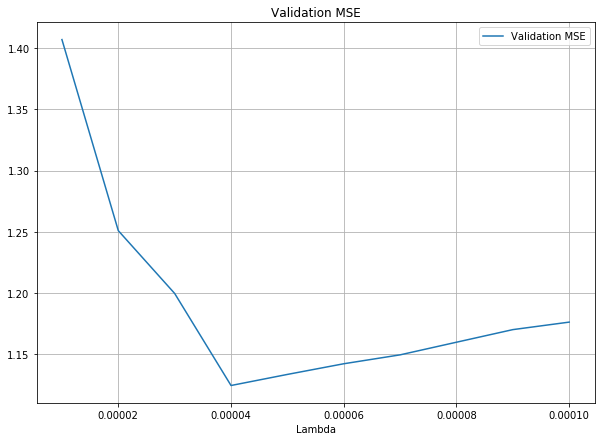

In [25]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.xlabel('Lambda')
plt.title('Validation MSE')
plt.grid(True)

plt.plot(lamb_values, MSE_valid, label='Validation MSE')

plt.legend()
plt.show()

In [22]:
MSE_valid

[1.1762428737095598,
 1.1701137762492688,
 1.159828537314749,
 1.1495096132941405,
 1.14223720979456,
 1.1335255087998408,
 1.1244750401368946,
 1.199644783486344,
 1.2509216904942775,
 1.406965792350448]

In [23]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()